In [10]:
import os
import torch
import argparse
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

In [24]:
def load_weights(weight_dir, param_name):
    ckpt_dict = {}
    for file_name in os.listdir(weight_dir):
        if file_name.endswith('.pth'):
            ckpt_num = file_name.split('.')[0].split('_')[-1]
            if ckpt_num == "final":
                continue
            ckpt_dict[int(ckpt_num)] = os.path.join(weight_dir, file_name)

    ckpt_dict = dict(sorted(ckpt_dict.items()))
    weights_matrix = []
    for ckpt_num, ckpt_path in ckpt_dict.items():
        ckpt = torch.load(ckpt_path)

        model_dict = ckpt["model"]
        for key_name in model_dict.keys():
            if key_name in param_name:
                weights_matrix.append(model_dict[key_name].cpu().flatten().numpy())
    weights_matrix = np.stack(weights_matrix)
    print(weights_matrix.shape)
    return weights_matrix


In [32]:
# param_name = "proposal_generator.rpn_head.conv.weight"

weight_dir = "../checkpoints/coco/exp1020/fsod_r101_base/fsrw-like/1shot_seed0"
weight2_dir = "../checkpoints/coco/exp1020/fsod_r101_novel/fsrw-like/1shot_seed0"
weight3_dir = "../checkpoints/coco/exp1020/ft_r101_novel"
param_list = ['proposal_generator.rpn_head.conv.weight', 'proposal_generator.rpn_head.conv.bias', 'proposal_generator.rpn_head.objectness_logits.weight', 'proposal_generator.rpn_head.objectness_logits.bias', 'proposal_generator.rpn_head.anchor_deltas.weight', 'proposal_generator.rpn_head.anchor_deltas.bias', 'roi_heads.box_head.fc1.weight', 'roi_heads.box_head.fc1.bias', 'roi_heads.box_head.fc2.weight', 'roi_heads.box_head.fc2.bias', 'roi_heads.box_predictor.cls_score.weight', 'roi_heads.box_predictor.cls_score.bias', 'roi_heads.box_predictor.bbox_pred.weight', 'roi_heads.box_predictor.bbox_pred.bias']
I = 0
weight_matrix = load_weights(weight_dir, param_list[I])
weight_matrix2 = load_weights(weight2_dir, param_list[I])
weight_matrix3 = load_weights(weight3_dir, param_list[I])
print(param_list[I])

(10, 589824)
(10, 589824)
(18, 589824)
proposal_generator.rpn_head.conv.weight


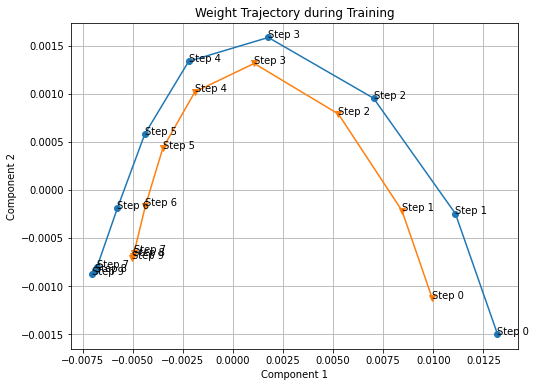

In [30]:
pca = PCA(n_components=2)
weights_embedded = pca.fit_transform(weight_matrix)
weights_embedded2 = pca.fit_transform(weight_matrix2)

plt.figure(figsize=(8, 6))
plt.plot(weights_embedded[:, 0], weights_embedded[:, 1], '-o')
plt.plot(weights_embedded2[:, 0], weights_embedded2[:, 1], '-v')

for i in range(weight_matrix.shape[0]):
    plt.text(weights_embedded[i, 0], weights_embedded[i, 1], f'Step {i}')
for i in range(weight_matrix2.shape[0]):
    plt.text(weights_embedded2[i, 0], weights_embedded2[i, 1], f'Step {i}')

plt.title('Weight Trajectory during Training')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()



In [33]:
def plot_weight(weight_matrix, weight_matrix2):
    labels1 = np.zeros((weight_matrix.shape[0],), dtype=np.int32)
    labels2 = np.ones((weight_matrix2.shape[0],), dtype=np.int32)
    text = np.concatenate(([f'step {i}' for i in range(weight_matrix.shape[0])], [f'step {i}' for i in range(weight_matrix2.shape[0])]), axis=0)
    X = np.concatenate((weight_matrix, weight_matrix2), axis=0)
    Y = np.concatenate((labels1, labels2), axis=0)

    cols = [f'feature_{i}' for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=cols)
    df['label'] = Y
    df['text'] = text

    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[cols].values)
    df['pca-one'] = pca_result[:, 0]
    df['pca-two'] = pca_result[:, 1]
    df['pca-three'] = pca_result[:, 2]



    fig = go.Figure()

    # Model 1 (label=0)
    fig.add_trace(go.Scatter3d(
        x=df[df['label'] == 0]['pca-one'],
        y=df[df['label'] == 0]['pca-two'],
        z=df[df['label'] == 0]['pca-three'],
        mode='markers+text',  # 显示标注
        text=df[df['label'] == 0]['text'],  # 添加标注文字
        marker=dict(
            size=3,
            color='rgba(40, 120, 181, 0.9)', 
            opacity=0.7
        ),
        name='Base'
    ))

    # Model 2 (label=1)
    fig.add_trace(go.Scatter3d(
        x=df[df['label'] == 1]['pca-one'],
        y=df[df['label'] == 1]['pca-two'],
        z=df[df['label'] == 1]['pca-three'],
        mode='markers+text',  # 显示标注
        text=df[df['label'] == 1]['text'],  # 添加标注文字
        marker=dict(
            size=3,
            color='rgba(225, 36, 35, 0.9)', 
            opacity=0.7
        ),
        name='Novel'
    ))

    fig.update_layout(
        title='Comparison of Weight Matrices via PCA with Text Labels',
        scene=dict(
            xaxis_title='PCA Component 1',
            yaxis_title='PCA Component 2',
            zaxis_title='PCA Component 3'
        ),
        legend_title_text='Models', 
        margin=dict(l=0, r=0, b=0, t=30)
    )

    fig.show()


In [35]:
plot_weight(weight_matrix2, weight_matrix3)

In [36]:
plot_weight(weight_matrix, weight_matrix3)